In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#read the input drug-metabolite data
data = pd.read_csv('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\data\\4-AMINO-3-PENTADECYLPHENOL_metabolic_NCI.csv')
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-[6-deoxy-a-L-galactopyranosyl-(1->4)]-O-b-D-galactopyranosyl-(1->4)-O-[6-deoxy-a-L-galactopyranosyl-(1->3)]-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso6] ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso3]","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),cells,Cell names,4-AMINO-3-PENTADECYLPHENOL
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,0.036367,0.025836,0.075427,0.036502,0.019935,0.032820,0.039391,BT549,BR:BT-549,6.516667
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,0.024981,0.013982,0.054200,0.029125,0.010750,0.015981,0.035154,HS578T,BR:HS 578T,4.770000


In [4]:
#drop the target drug response variable
drug = data.pop(data.columns[-1])

In [5]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()

In [6]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites
X = X[rep_meta]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [7]:
X.shape

(52, 197)

In [8]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [9]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [10]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

1    30
0    22
dtype: int64

In [11]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [12]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,1.538719,-0.109001,-0.779266,-0.779768,0.279413,-0.560268,0.309368,-0.409786,-0.357655,0.760016,...,-1.103313,-1.020121,-0.299559,-1.079263,0.940396,-1.270742,-0.321639,0.431682,-0.651410,1.143094
1,-0.193863,0.635887,-0.425364,-0.153889,0.828419,-0.259167,-1.021683,-1.002871,-1.034593,1.283211,...,-0.735956,-0.227727,-1.050058,-0.051904,-0.764161,-1.135280,-0.995013,-2.065271,-1.539887,0.770433


In [13]:
X.shape, y.shape

((60, 197), (60,))

In [14]:
y.value_counts()

0    30
1    30
dtype: int64

In [15]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [16]:
X_train.shape, X_test.shape

((48, 197), (12, 197))

In [17]:
y_train.value_counts(), y_test.value_counts()

(0    24
 1    24
 dtype: int64,
 1    6
 0    6
 dtype: int64)

In [18]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 80
Number of features selected during iteration 1: 67
Number of features selected during iteration 2: 75
Number of features selected during iteration 3: 75
Number of features selected during iteration 4: 78
Number of features selected during iteration 5: 74
Number of features selected during iteration 6: 77
Number of features selected during iteration 7: 75
Number of features selected during iteration 8: 77
Number of features selected during iteration 9: 71
Number of features selected during iteration 10: 72
Number of features selected during iteration 11: 79
Number of features selected during iteration 12: 70
Number of features selected during iteration 13: 72
Number of features selected during iteration 14: 71
Number of features selected during iteration 15: 71
Number of features selected during iteration 16: 74
Number of features selected during iteration 17: 81
Number of features selected during iteration 18: 78
Number of features sel

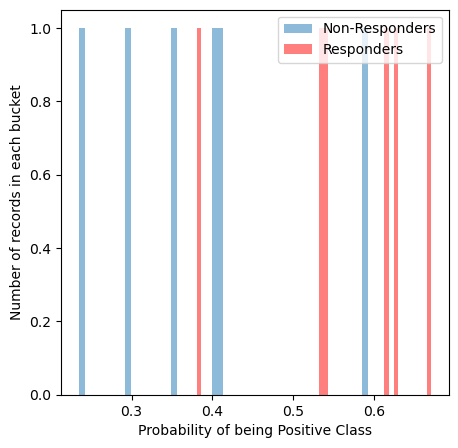

In [19]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5, bins = 50)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [20]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()
df1

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.538719,-0.109001,-0.779266,-0.779768,0.279413,-0.560268,0.309368,-0.409786,-0.357655,0.760016,...,-0.299559,-1.079263,0.940396,-1.270742,-0.321639,0.431682,-0.651410,1.143094,NaN,NaN
1,-0.193863,0.635887,-0.425364,-0.153889,0.828419,-0.259167,-1.021683,-1.002871,-1.034593,1.283211,...,-1.050058,-0.051904,-0.764161,-1.135280,-0.995013,-2.065271,-1.539887,0.770433,NaN,NaN
2,1.024043,0.966375,-1.075842,-0.420648,0.772681,-0.681447,0.844974,0.722520,0.729468,-0.517182,...,0.151444,-0.955038,-0.002440,-1.160287,-0.183538,-0.450944,-0.535694,-0.184704,NaN,NaN
3,-1.344718,-1.379760,0.917919,0.847470,1.367991,-0.449238,0.402638,1.717943,1.890539,-0.625136,...,-0.024088,-0.313880,0.464181,0.109780,-0.271489,-0.731900,0.634800,-0.771477,NaN,NaN
4,-1.369076,0.019112,-0.438628,0.331186,-1.197408,-0.676930,-0.700913,-0.134726,-0.471450,-0.757468,...,-1.140582,0.171260,-1.466084,0.999873,-1.895494,-0.566750,-1.057304,-0.035440,NaN,NaN
5,-0.036825,0.019112,-0.613155,-0.142160,0.150655,-0.334375,1.281616,0.828732,0.540841,1.724873,...,-0.320151,0.377868,0.196095,0.565508,-1.279512,1.205455,0.672175,-1.032483,0.592133,0.0
6,0.059340,-1.586131,-0.220626,0.471609,-0.371996,-0.086448,-1.115944,-0.614167,-0.746491,0.167582,...,-0.494231,-0.850507,-0.242523,0.110389,0.229759,-0.757896,-0.368154,1.782661,NaN,NaN
7,-1.945536,0.019112,0.394869,0.041116,0.074706,-0.191806,-0.585158,-1.192993,-1.367954,1.659866,...,-1.989114,-0.737135,-1.913871,0.685229,-1.490557,-1.192954,-0.971994,-1.381098,NaN,NaN
8,-0.759619,-0.388412,-0.790453,-1.237882,0.768153,-0.770324,0.203048,1.317972,1.736831,-0.225068,...,0.311458,-1.008264,0.077381,-0.881674,-0.324520,0.145880,0.289163,0.068833,NaN,NaN
9,2.543561,-1.113610,-0.002215,0.633002,0.409299,-0.554428,0.327981,0.191036,0.292547,0.308456,...,0.149576,-1.019006,0.694271,-0.246643,0.493157,0.115703,0.283510,0.635762,NaN,NaN


In [21]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(3, 199)

In [22]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 72
Features selected during iteration 1: 72
Features selected during iteration 2: 73
Features selected during iteration 3: 72
Features selected during iteration 4: 80
Features selected during iteration 5: 73
Features selected during iteration 6: 67
Features selected during iteration 7: 79
Features selected during iteration 8: 75
Features selected during iteration 9: 83
Features selected during iteration 10: 74
Features selected during iteration 11: 75
Features selected during iteration 12: 76
Features selected during iteration 13: 79
Features selected during iteration 14: 68
Features selected during iteration 15: 73
Features selected during iteration 16: 76
Features selected during iteration 17: 66
Features selected during iteration 18: 82
Features selected during iteration 19: 73
Features selected during iteration 20: 77
Features selected during iteration 21: 73
Features selected during iteration 22: 75
Features selected during iteration 23: 66
Fe

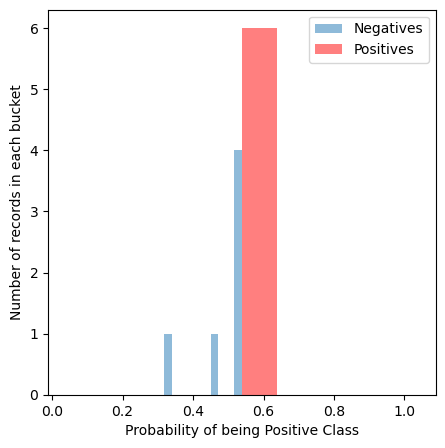

In [23]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [24]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [25]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target


In [26]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 33
Features selected during iteration 1: 33
Features selected during iteration 2: 33
Features selected during iteration 3: 33
Features selected during iteration 4: 33
Features selected during iteration 5: 33
Features selected during iteration 6: 33
Features selected during iteration 7: 33
Features selected during iteration 8: 33
Features selected during iteration 9: 33
Features selected during iteration 10: 33
Features selected during iteration 11: 33
Features selected during iteration 12: 33
Features selected during iteration 13: 33
Features selected during iteration 14: 33
Features selected during iteration 15: 33
Features selected during iteration 16: 33
Features selected during iteration 17: 33
Features selected during iteration 18: 33
Features selected during iteration 19: 33
Features selected during iteration 20: 33
Features selected during iteration 21: 33
Features selected during iteration 22: 33
Features selected during iteration 23: 33
Fe

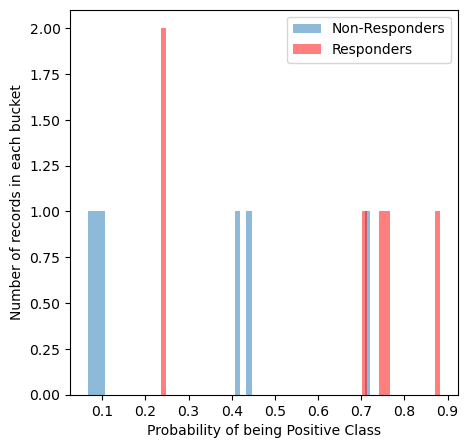

In [27]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [28]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.538719,-0.109001,-0.779266,-0.779768,0.279413,-0.560268,0.309368,-0.409786,-0.357655,0.760016,...,-0.299559,-1.079263,0.940396,-1.270742,-0.321639,0.431682,-0.651410,1.143094,NaN,NaN
1,-0.193863,0.635887,-0.425364,-0.153889,0.828419,-0.259167,-1.021683,-1.002871,-1.034593,1.283211,...,-1.050058,-0.051904,-0.764161,-1.135280,-0.995013,-2.065271,-1.539887,0.770433,NaN,NaN
2,1.024043,0.966375,-1.075842,-0.420648,0.772681,-0.681447,0.844974,0.722520,0.729468,-0.517182,...,0.151444,-0.955038,-0.002440,-1.160287,-0.183538,-0.450944,-0.535694,-0.184704,NaN,NaN
3,-1.344718,-1.379760,0.917919,0.847470,1.367991,-0.449238,0.402638,1.717943,1.890539,-0.625136,...,-0.024088,-0.313880,0.464181,0.109780,-0.271489,-0.731900,0.634800,-0.771477,NaN,NaN
4,-1.369076,0.019112,-0.438628,0.331186,-1.197408,-0.676930,-0.700913,-0.134726,-0.471450,-0.757468,...,-1.140582,0.171260,-1.466084,0.999873,-1.895494,-0.566750,-1.057304,-0.035440,NaN,NaN
5,-0.036825,0.019112,-0.613155,-0.142160,0.150655,-0.334375,1.281616,0.828732,0.540841,1.724873,...,-0.320151,0.377868,0.196095,0.565508,-1.279512,1.205455,0.672175,-1.032483,0.407478,0.0
6,0.059340,-1.586131,-0.220626,0.471609,-0.371996,-0.086448,-1.115944,-0.614167,-0.746491,0.167582,...,-0.494231,-0.850507,-0.242523,0.110389,0.229759,-0.757896,-0.368154,1.782661,NaN,NaN
7,-1.945536,0.019112,0.394869,0.041116,0.074706,-0.191806,-0.585158,-1.192993,-1.367954,1.659866,...,-1.989114,-0.737135,-1.913871,0.685229,-1.490557,-1.192954,-0.971994,-1.381098,NaN,NaN
8,-0.759619,-0.388412,-0.790453,-1.237882,0.768153,-0.770324,0.203048,1.317972,1.736831,-0.225068,...,0.311458,-1.008264,0.077381,-0.881674,-0.324520,0.145880,0.289163,0.068833,NaN,NaN
9,2.543561,-1.113610,-0.002215,0.633002,0.409299,-0.554428,0.327981,0.191036,0.292547,0.308456,...,0.149576,-1.019006,0.694271,-0.246643,0.493157,0.115703,0.283510,0.635762,NaN,NaN


In [29]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
28,1.458491,2.620582,0.323473,0.325129,-0.616874,0.442093,0.485352,-0.074192,-0.261494,1.676426,...,0.090766,-0.051904,0.188135,-0.396791,1.353951,0.237389,-0.423064,0.515747,0.882588,1.0
37,0.059340,-0.025957,-0.597268,-0.403965,-1.338066,0.109584,-1.195530,-1.506024,-1.411573,0.064097,...,-1.095501,0.020596,-0.543626,-0.643093,-1.009173,-1.516902,-1.277718,-0.845447,0.741661,1.0
43,-0.063244,0.236338,0.217325,0.836154,0.471775,0.525114,-0.037339,0.781567,0.547960,2.968724,...,0.070631,-0.300810,0.404163,-0.536743,0.528916,1.122466,-0.188072,1.813172,0.761872,1.0


In [30]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [31]:
cl = set(common_list)
cl

{14, 28, 37, 43}

In [32]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
14,0.530871,-0.161375,1.152588,0.463784,-0.626098,1.240787,0.760874,-0.791527,-0.986439,-1.729722,...,0.042520,0.746148,1.396799,0.650706,0.962790,0.488032,0.764511,0.253143,0.670400,1.0
18,-0.673470,-1.609330,0.098929,-0.237561,-1.305879,-0.548021,0.249461,-0.881940,-0.930566,-0.939484,...,-0.386611,0.008392,0.185484,0.840512,-0.033591,-0.288173,-0.835139,1.338906,0.380267,1.0
22,0.432757,0.019112,2.522418,-0.695052,0.026079,0.287312,1.060045,0.749606,0.640886,-1.242999,...,0.028069,-0.284377,0.194543,2.422939,0.502948,0.343876,0.597495,1.002570,0.539067,1.0
28,1.458491,2.620582,0.323473,0.325129,-0.616874,0.442093,0.485352,-0.074192,-0.261494,1.676426,...,0.090766,-0.051904,0.188135,-0.396791,1.353951,0.237389,-0.423064,0.515747,0.616933,1.0
37,0.059340,-0.025957,-0.597268,-0.403965,-1.338066,0.109584,-1.195530,-1.506024,-1.411573,0.064097,...,-1.095501,0.020596,-0.543626,-0.643093,-1.009173,-1.516902,-1.277718,-0.845447,0.532000,1.0
43,-0.063244,0.236338,0.217325,0.836154,0.471775,0.525114,-0.037339,0.781567,0.547960,2.968724,...,0.070631,-0.300810,0.404163,-0.536743,0.528916,1.122466,-0.188072,1.813172,0.625867,1.0


In [33]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [34]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')